### Import Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 33.8 MB/s 


In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import seaborn as sns
import os
import pathlib
import glob
import h5py
import shutil
import random
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from tqdm import tqdm
import cv2
import PIL
from IPython.display import Image
import pathlib
from pathlib import Path
import itertools
from itertools import cycle

#import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model, load_model
from keras.layers import Lambda, Conv2D, MaxPooling2D, MaxPool2D, Dense, Dropout, Input, Flatten, SeparableConv2D, Activation, Concatenate, BatchNormalization
from keras.callbacks import *
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Nadam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input, decode_predictions
import tensorflow_addons as tfa

from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer, label_binarize
from sklearn.multiclass import OneVsRestClassifier

# stop annoying tensorflow warning messages
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Load the TensorBoard notebook extension
#%load_ext tensorboard

print("TensorFlow Version:", tf.__version__)


TensorFlow Version: 2.8.0


In [5]:
tf.random.set_seed(42)

### Define hyperparameters

In [6]:
batch_size = 32
img_height = 224
img_width = 224
img_channel = 3
epochs = 100
img_size=(img_width, img_height)
img_shape=(img_width, img_height, img_channel)

### **Load Data 2**

**Data Preparation**

In [7]:
data_path = '/content/drive/MyDrive/Datasets/Curated 3Class/'

Train = data_path + 'train/'
Val   = data_path + 'val/'
Test  = data_path + 'test/'


# create a dictionary with names & indices
class_names = ['COVID-19', 'Normal', 'Pneumonia']
class_dict  = {0:'COVID-19', 1:'Normal', 2:'Pneumonia'}
class_index = {'COVID-19':0 ,'Normal':1,'Pneumonia':2}
class_names

['COVID-19', 'Normal', 'Pneumonia']

In [ ]:
# Open Folders
# let's first check the folders to have a look to its content

for folder in  os.listdir(Train) : 
    files = glob.glob(pathname= str( Train +'/' + folder + '/*'))
    print(f'For training data , found {len(files)} in folder {folder}')
    
print('-----------------')

for folder in  os.listdir(Val) : 
    files = glob.glob(pathname= str( Val +'/' + folder + '/*'))
    print(f'For validation data , found {len(files)} in folder {folder}')

print('-----------------')

for folder in  os.listdir(Test) : 
    files = glob.glob(pathname= str( Test +'/' + folder + '/*'))
    print(f'For testing data , found {len(files)} in folder {folder}')

For training data , found 896 in folder COVID-19
For training data , found 3518 in folder Pneumonia
For training data , found 2410 in folder Normal
-----------------
For validation data , found 185 in folder COVID-19
For validation data , found 700 in folder Pneumonia
For validation data , found 460 in folder Normal
-----------------
For testing data , found 200 in folder COVID-19
For testing data , found 400 in folder Pneumonia
For testing data , found 400 in folder Normal


### **Dataset Appending**

In [8]:
X_train = []
y_train = []

for folder in  os.listdir(Train) : 
    files = glob.glob(pathname= str(Train +'/' + folder + '/*'))
    for file in files: 
        image = cv2.imread(file)
        #image_array = cv2.resize(image , img_size)
        X_train.append(list(image))
        y_train.append(class_index[folder])

print(f'we have {len(X_train)} items in X_train')

X_val = []
y_val = []
for folder in  os.listdir(Val) : 
    files = glob.glob(pathname= str(Val +'/' + folder + '/*'))
    for file in files: 
        image = cv2.imread(file)
        #image_array = cv2.resize(image , img_size)
        X_val.append(list(image))
        y_val.append(class_index[folder])
        
print(f'we have {len(X_val)} items in X_val')

X_test = []
y_test = []
for folder in  os.listdir(Test) : 
    files = glob.glob(pathname= str(Test +'/' + folder + '/*'))
    for file in files: 
        image = cv2.imread(file)
        #image_array = cv2.resize(image , img_size)
        X_test.append(list(image))
        y_test.append(class_index[folder])
        
print(f'We have {len(X_test)} items in X_test')


we have 6824 items in X_train
we have 1345 items in X_val
We have 1000 items in X_test


### **Dataset samples**

In [ ]:
# Create a function to get the code back
def getcode(n) : 
    for x , y in class_index.items() : 
        if n == y : 
            return x

plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_train),16))) : 
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i])   
    plt.axis('off')
    plt.title(getcode(y_train[i]))

### **Preprocessing**

In [9]:
#Convert list to numpy array
X_trainA = np.array(X_train)
y_train  = np.array(y_train)
y_trainC = to_categorical(y_train)

X_valA = np.array(X_val) 
y_val  = np.array(y_val)
y_valC = to_categorical(y_val)

X_testA = np.array(X_test) 
y_test  = np.array(y_test)
y_testC = to_categorical(y_test)

print('Train shape  is:',X_trainA.shape,y_trainC.shape)
print('Val shape  is:',X_valA.shape,y_valC.shape)
print('Test shape  is',X_testA.shape,y_testC.shape)

Train shape  is: (6824, 224, 224, 3) (6824, 3)
Val shape  is: (1345, 224, 224, 3) (1345, 3)
Test shape  is (1000, 224, 224, 3) (1000, 3)


### **Exploring the Data** 
**Visualize class distribution in train set**

In [ ]:
# Check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []

for i in os.listdir(Train):
  train_class = os.listdir(os.path.join(Train, i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))


In [ ]:
folder_path = Test
all_items, dirs, files = next(os.walk(folder_path))

image_in_classes = []
colors = ['C0','C1','C2']

for i in range(len(dirs)):
    no_of_images =len(os.listdir(os.path.join(folder_path,dirs[i])))
    image_in_classes.append(no_of_images)
df_data = {'Class counts': dirs,'No. of images': image_in_classes}
classes_df = pd.DataFrame(df_data)   

ax = sns.barplot(x = 'Class counts', y = 'No. of images', data = classes_df, palette=colors)
ax.set_xlabel('Class counts', fontsize=15)
ax.set_ylabel('No. of images', fontsize=15)
plt.title('Testing set', fontsize = 15)
plt.ylim(0,4000)
plt.xticks([0,1,2], class_names, fontsize = 15, rotation= 25)
for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.15, p.get_height()+100), fontsize = 15)


plt.figure(figsize=(8, 8))

plt.pie(No_images_per_class, 
        labels = Class_name, 
        autopct = '%1.1f%%',
        textprops={'fontsize': 15},
        colors= colors)
plt.show()

### **Callbacks**

In [10]:
earlystop = [ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             save_weights_only=True),
                             
            # val_loss must be decrease
            EarlyStopping(monitor ="val_loss", 
                            patience=10,
                            min_delta=.0001,
                            restore_best_weights = True,
                            verbose=1
                            )]  

# val_accuracy must be increase
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1,  #  0: quiet, 1: update messages.
                                            factor=0.2, # factor by which the learning rate will be reduced (new_lr = lr * factor).
                                            min_lr=0.0000001,
                                            )


my_callbacks = [earlystop, learning_rate_reduction]

### **`Data Augmentation`**

In [ ]:
from imgaug import augmenters as iaa
import imgaug as ia
AUTO = tf.data.AUTOTUNE

rand_aug = iaa.RandAugment(n=3, m=7)

def augment(images):
    # Input to `augment()` is a TensorFlow tensor which is not supported by `imgaug`. This is why we first
    # convert it to its `numpy` variant.
    images = tf.cast(images, tf.uint8)
    return rand_aug(images=images.numpy())

#### **Create TensorFlow `Dataset` objects**

In [ ]:
train_ds_rand = (
    tf.data.Dataset.from_tensor_slices((X_trainA, y_trainC))
    .shuffle(batch_size * 100)
    .batch(batch_size)
    #.map(lambda x, y: (tf.image.resize(x, (72, 72)), y), num_parallel_calls=AUTO)
    
    # The returned output of `tf.py_function` contains an unncessary axis of 1-D and we need to remove it.
    .map(lambda x, y: (tf.py_function(augment, [x], [tf.float32])[0], y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_valA, y_valC))
    .batch(batch_size)
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((X_testA, y_testC))
    .batch(batch_size)
    .prefetch(AUTO)
)

#### **Visualize the dataset augmented with RandAugment**

In [ ]:
sample_images, _ = next(iter(train_ds_rand))
plt.figure(figsize=(15, 15))
for i, image in enumerate(sample_images[:30]):
    ax = plt.subplot(5, 6, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

In [ ]:
# extract data/labels back from TensorFlow dataset
train_ds = train_ds_rand.unbatch()
train_ds_X_train = np.asarray(list(train_ds.map(lambda x, y: x)))

In [ ]:
len(X_train)

In [ ]:
len(train_ds_X_train)

### **Ranger Optimizer**

In [11]:
def Ranger(sync_period=6,
           slow_step_size=0.5,
           learning_rate=0.001,
           beta_1=0.9,
           beta_2=0.999,
           epsilon=1e-7,
           weight_decay=0.,
           amsgrad=False,
           sma_threshold=5.0,
           total_steps=0,
           warmup_proportion=0.1,
           min_lr=0.,
           name="Ranger"):
    """
        function returning a tf.keras.optimizers.Optimizer object
        returned optimizer is a Ranger optimizer
        Ranger is an optimizer combining RAdam (https://arxiv.org/abs/1908.03265) and Lookahead (https://arxiv.org/abs/1907.0861)
        returned optimizer can be fed into the model.compile method of a tf.keras model as an optimizer
        ...
        Attributes
        ----------
        learning_rate : float
            step size to take for RAdam optimizer (depending on gradient)
        beta_1 : float
            parameter that specifies the exponentially moving average length for momentum (0<=beta_1<=1)
        beta_2 : float
            parameter that specifies the exponentially moving average length for variance (0<=beta_2<=1)
        epsilon : float
            small number to cause stability for variance division
        weight_decay : float
            number with which the weights of the model are multiplied each iteration (0<=weight_decay<=1)
        amsgrad : bool
            parameter that specifies whether to use amsgrad version of Adam (https://arxiv.org/abs/1904.03590)
        total_steps : int
            total number of training steps
        warmup_proportion : float
            the proportion of updated over which the learning rate is increased from min learning rate to learning rate (0<=warmup_proportion<=1)
        min_lr : float
            learning rate at which the optimizer starts
        k : int
            parameter that specifies after how many steps the lookahead step backwards should be applied
        alpha : float
            parameter that specifies how much in the direction of the fast weights should be moved (0<=alpha<=1)
    """
    # create RAdam optimizer
    Radam  = tfa.optimizers.RectifiedAdam(learning_rate, beta_1, beta_2, epsilon, weight_decay, amsgrad, sma_threshold, total_steps, warmup_proportion, min_lr, name)
    # feed RAdam optimizer into lookahead operation
    optim = tfa.optimizers.Lookahead(Radam, sync_period, slow_step_size, name)
    return optim


### **Download MobileNetV2 Weights**

In [12]:
base_model = EfficientNetV2B0(input_shape=img_shape,
                    include_top=False, 
                    weights='/content/drive/MyDrive/Colab Notebooks/efficientnetv2-b0_notop.hdf'
                    #pooling='max'
                    )

## Don't train existing weights
base_model.trainable=False
# layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  255


### **Build the model**
The Top layers (after base convloution layers) - you can add more if you want

In [13]:
input_img = Input(shape= img_shape) # Input shape

x = base_model(input_img, training=False)

x = layers.GlobalAveragePooling2D()(x)

initializer = keras.initializers.HeNormal(seed=42)

x = Dense(1024, activation='LeakyReLU', kernel_initializer=initializer)(x)
# x = Dropout(0.5)(x)
x = Dense(1024, activation='LeakyReLU', kernel_initializer=initializer)(x)


prediction=Dense(len(os.listdir(Train)), activation = "softmax", kernel_initializer=initializer)(x)

## create a model object
model=Model(inputs=input_img, outputs=prediction, name="EfficientNetV2B0")

METRICS = [
      keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'),
]

model.compile(optimizer = Ranger(), 
            loss = keras.losses.CategoricalCrossentropy(), 
            metrics = METRICS
            )

# view the structure of the model
model.summary()

Model: "EfficientNetV2B0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 3)            

#### **plot_model**

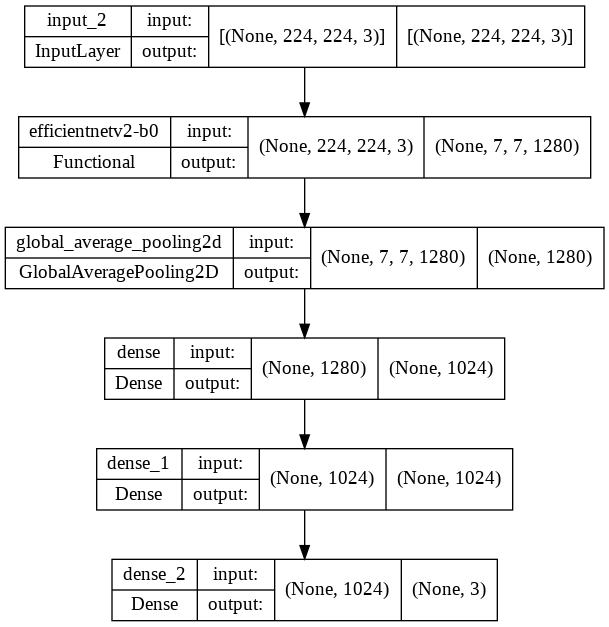

In [ ]:
plot_model(model, show_shapes=True)

### **Assigning Class Weights**

In [14]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train), # dataset_classes  or y_test
                                        y = y_train                                                    
                                    )
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 2.5386904761904763, 1: 0.9438450899031812, 2: 0.6465794959257154}

### **Train the model**
len(train_set) ===equal=== train_set//Batch_Size

In [15]:
%%time
history = model.fit(X_trainA, y_trainC,
                epochs= epochs,
                validation_data= (X_valA, y_valC), 
                callbacks = my_callbacks,
                batch_size = batch_size,
                class_weight= class_weights
              )

Epoch 1/100
214/214 [==============================] - ETA: 0s - loss: 0.2678 - Categorical_Accuracy: 0.8974
Epoch 1: val_loss improved from inf to 0.10910, saving model to model.01-0.11.h5
214/214 [==============================] - 34s 75ms/step - loss: 0.2678 - Categorical_Accuracy: 0.8974 - val_loss: 0.1091 - val_Categorical_Accuracy: 0.9665 - lr: 0.0010
Epoch 2/100
213/214 [============================>.] - ETA: 0s - loss: 0.0995 - Categorical_Accuracy: 0.9583
Epoch 2: val_loss did not improve from 0.10910
214/214 [==============================] - 14s 65ms/step - loss: 0.0994 - Categorical_Accuracy: 0.9584 - val_loss: 0.1262 - val_Categorical_Accuracy: 0.9561 - lr: 0.0010
Epoch 3/100
213/214 [============================>.] - ETA: 0s - loss: 0.0823 - Categorical_Accuracy: 0.9667
Epoch 3: val_loss improved from 0.10910 to 0.08438, saving model to model.03-0.08.h5
214/214 [==============================] - 14s 68ms/step - loss: 0.0824 - Categorical_Accuracy: 0.9666 - val_loss: 0.084

### Save and Load the model/weights

In [ ]:
model.save("Model Backup")

### Evaluation 

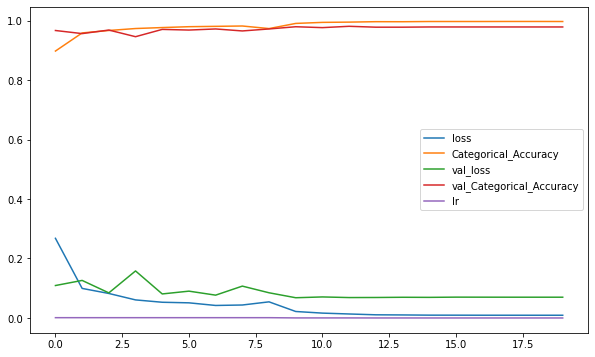

In [16]:
pd.DataFrame(model.history.history).plot(figsize=(10, 6))

In [ ]:
print("Loss of the model is : " , model.evaluate(X_testA, verbose=1)[0])
#print("Accuracy of the model is : " , model.evaluate(test_set, verbose=1)[1]*100 , "%")

### **Prediction**

In [17]:
# predict 
preds = model.predict(X_testA, verbose=1, batch_size=1)
preds = np.argmax(preds, axis=1)
# label
y_testCM = np.argmax(y_testC, axis=1)

print(preds.min())
print(preds.max())
# print(preds)

1000/1000 [==============================] - 12s 11ms/step
0
2


### **Confusion matrix**

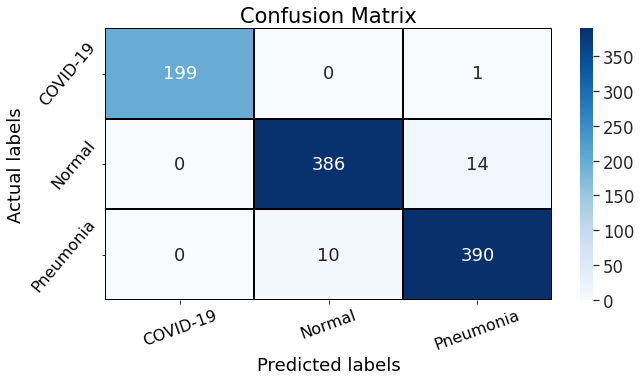

In [18]:
cm = confusion_matrix(y_testCM, preds)

plt.figure(figsize = (10,5))
ax0 = plt.subplot()
sns.set(font_scale=1.5) # Adjust to fit
sns.heatmap(cm, cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt="d")

# Labels, title and ticks
label_font = {'size':'18'}  # Adjust to fit
ax0.set_xlabel('Predicted labels', fontdict=label_font);
ax0.set_ylabel('Actual labels', fontdict=label_font);

title_font = {'size':'21'}  # Adjust to fit
ax0.set_title('Confusion Matrix', fontdict=title_font);

ax0.tick_params(axis='both', which='major', labelsize=16)  # Adjust to fit
ax0.xaxis.set_ticklabels(class_names, rotation=20); 
ax0.yaxis.set_ticklabels(class_names, rotation=50);

In [19]:
print(classification_report(y_true=y_testCM, 
                            y_pred=preds,
                            target_names = class_names))
####################################################################
TP = np.diag(cm)
FP = cm.sum(axis=0) - np.diag(cm) 
FN = cm.sum(axis=1) - np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

TP = TP.astype(float)
FP = FP.astype(float)
FN = FN.astype(float)
TN = TN.astype(float)

print('\nTEST METRICS ----------------------')
acc = accuracy_score(y_testCM, np.round(preds))*100

# Sensitivity, Recall, hit rate, or true positive rate (TPR)
Sensitivity = (TP/(TP+FN))*100
# Specificity, Selectivity or true negative rate (TNR)
Specificity= (TN/(TN+FP))*100
# Precision or positive predictive value (PPV)
Precision = (TP/(TP+FP))*100
#F1-score(is the harmonic mean of precision and sensitivity
F1_score = (2*Precision*Sensitivity/(Precision+Sensitivity))
# Negative predictive value
NPV = (TN/(TN+FN))*100
# Fall out or false positive rate
FPR = (FP/(FP+TN))*100
# False negative rate
FNR = (FN/(TP+FN))*100
# False discovery rate
FDR = (FP/(TP+FP))*100
# Overall accuracy for each class
overall_ACC = ((TP+TN)/(TP+FP+FN+TN))*100

print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(Precision))
print('Sensitivity: {}%'.format(Sensitivity))
print('Specificity: {}%'.format(Specificity))
print('F1-score: {}%'.format(F1_score))
print('Overall Accuracy: {}%'.format(overall_ACC))

print('\nTRAIN METRIC ----------------------')
print('Accuracy: {}'.format(np.round((history.history['Categorical_Accuracy'][-1])*100, 2)))

              precision    recall  f1-score   support

    COVID-19       1.00      0.99      1.00       200
      Normal       0.97      0.96      0.97       400
   Pneumonia       0.96      0.97      0.97       400

    accuracy                           0.97      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.97      0.98      1000


TEST METRICS ----------------------
Accuracy: 97.5%
Precision: [100.          97.47474747  96.2962963 ]%
Sensitivity: [99.5 96.5 97.5]%
Specificity: [100.          98.33333333  97.5       ]%
F1-score: [99.74937343 96.98492462 96.89440994]%
Overall Accuracy: [99.9 97.6 97.5]%

TRAIN METRIC ----------------------
Accuracy: 99.68


### **ROC-AUC curve**

ROC AUC score: 0.9822222222222222


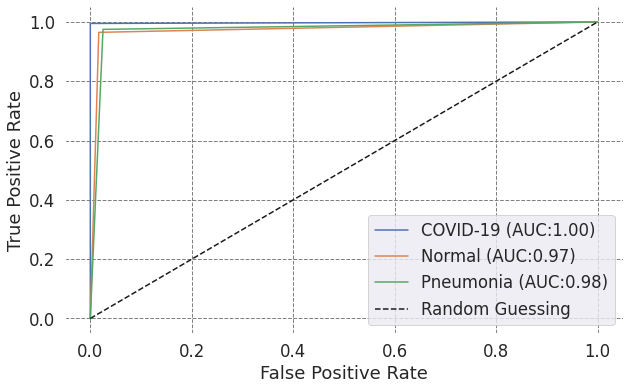

In [20]:
# set plot figure size
fig, c_ax = plt.subplots(1,1,figsize = (10, 6))
plt.style.use('seaborn-bright')
# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx,c_label) in enumerate(class_names): # all_labels: no of the labels, for ex. ['cat', 'dog', 'rat']
        fpr, tpr, _ = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'k--', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test, preds))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
c_ax.set_facecolor('white') # change backgound color
#c_ax.patch.set_linewidth(5) # change frame border width
#c_ax.patch.set_edgecolor('cornflowerblue') # change frame border color
c_ax.grid(color='gray', linestyle='--') # change grid color
sns.despine()
plt.show()


### **Learning curves**

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

In [ ]:
print(history.history.keys())

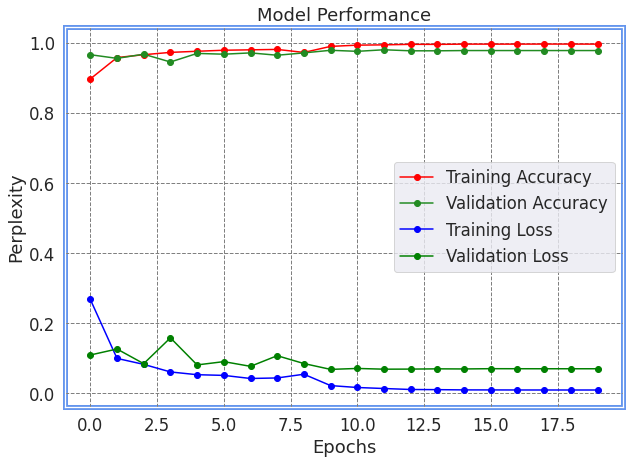

In [21]:
fig , ax = plt.subplots()
train_acc = history.history['Categorical_Accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_Categorical_Accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(10,7)
#fig.suptitle('Model Performance', fontsize=16)

epochRange = range(len(train_acc))

ax.plot(epochRange , train_acc , marker='o', linestyle='-', color='red', label ='Training Accuracy')
ax.plot(epochRange , val_acc   , marker='o', linestyle='-', color='forestgreen' , label = 'Validation Accuracy')
ax.plot(epochRange , train_loss, marker='o', linestyle='-', color='blue' , label = 'Training Loss')
ax.plot(epochRange , val_loss  , marker='o', linestyle='-', color='green' , label = 'Validation Loss')

ax.set_title('Model Performance')
ax.legend()
ax.set_xlabel("Epochs")
ax.set_ylabel("Perplexity")
ax.set_facecolor('white') # change backgound color
ax.patch.set_linewidth(5) # change frame border width
ax.patch.set_edgecolor('cornflowerblue') # change frame border color
ax.grid(color='gray', linestyle='--') # change grid color
plt.show()   

### **Predict single image**

In [ ]:
def get_img_array(img_path):
  path = img_path
  img = load_img(path, target_size=img_size, color_mode='rgb')
  img = img_to_array(img)
  img = np.expand_dims(img , axis= 0 )
  return img

In [ ]:
path1 = "D:/My Research/Publish Papers/3-MultiClasses/Dataset 1290 Splitted/test/Normal/h1322.png"
path2 = "D:/My Research/Publish Papers/3-MultiClasses/Dataset 1290 Splitted/test/COVID-19/COVID-19 (87).jpg"
path3 = "D:/My Research/Publish Papers/3-MultiClasses/Dataset 1290 Splitted/test/Bacterial-Pneumonia/Pneumonia-Bacterial (2755).jpg"
path4 = "D:/My Research/Publish Papers/3-MultiClasses/Dataset 1290 Splitted/test/Viral-Pneumonia/Pneumonia-Viral (479).jpg"

img = get_img_array(path4)

result = class_dict[np.argmax(model.predict(img))]
print(f"The given X-Ray image is of type : {result}")
print("\nThe Probability of each diseas as follow:")
print("----------------------------------------")
print(f"Normal is    : {round(model.predict(img)[0][0]*100,2)}%")
print(f"Covid-19 is  : {round(model.predict(img)[0][1]*100,2) }%")
print(f"Bacterial is : {round(model.predict(img)[0][2]*100,2) }%")
print(f"Viral is     : {round(model.predict(img)[0][3]*100,2) }%")

plt.imshow(img[0]/255, cmap = "gray")
plt.title("input image")
plt.show()

### **Predict from test set**

In [22]:
test_folder = Test

prediction = []
original = []
image = []
count = 0
for i in os.listdir(test_folder):
  for item in os.listdir(os.path.join(test_folder, i)):
    # code to open the image
    img= keras.preprocessing.image.load_img(os.path.join(test_folder, i, item), target_size=img_size, color_mode='rgb')
    #append to image list
    image.append(img)
    img = img_to_array(img)
    #expand dimension
    img = np.expand_dims(img, axis=0)
    #img /= 255
    #predict
    predict = model.predict(img)
    #get the index corresponding to the highest value in the prediction
    predictM = np.argmax(predict)
    #append the predicted class to the list
    prediction.append(class_dict[predictM])
    #append original class to the list
    original.append(i)

#test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.975


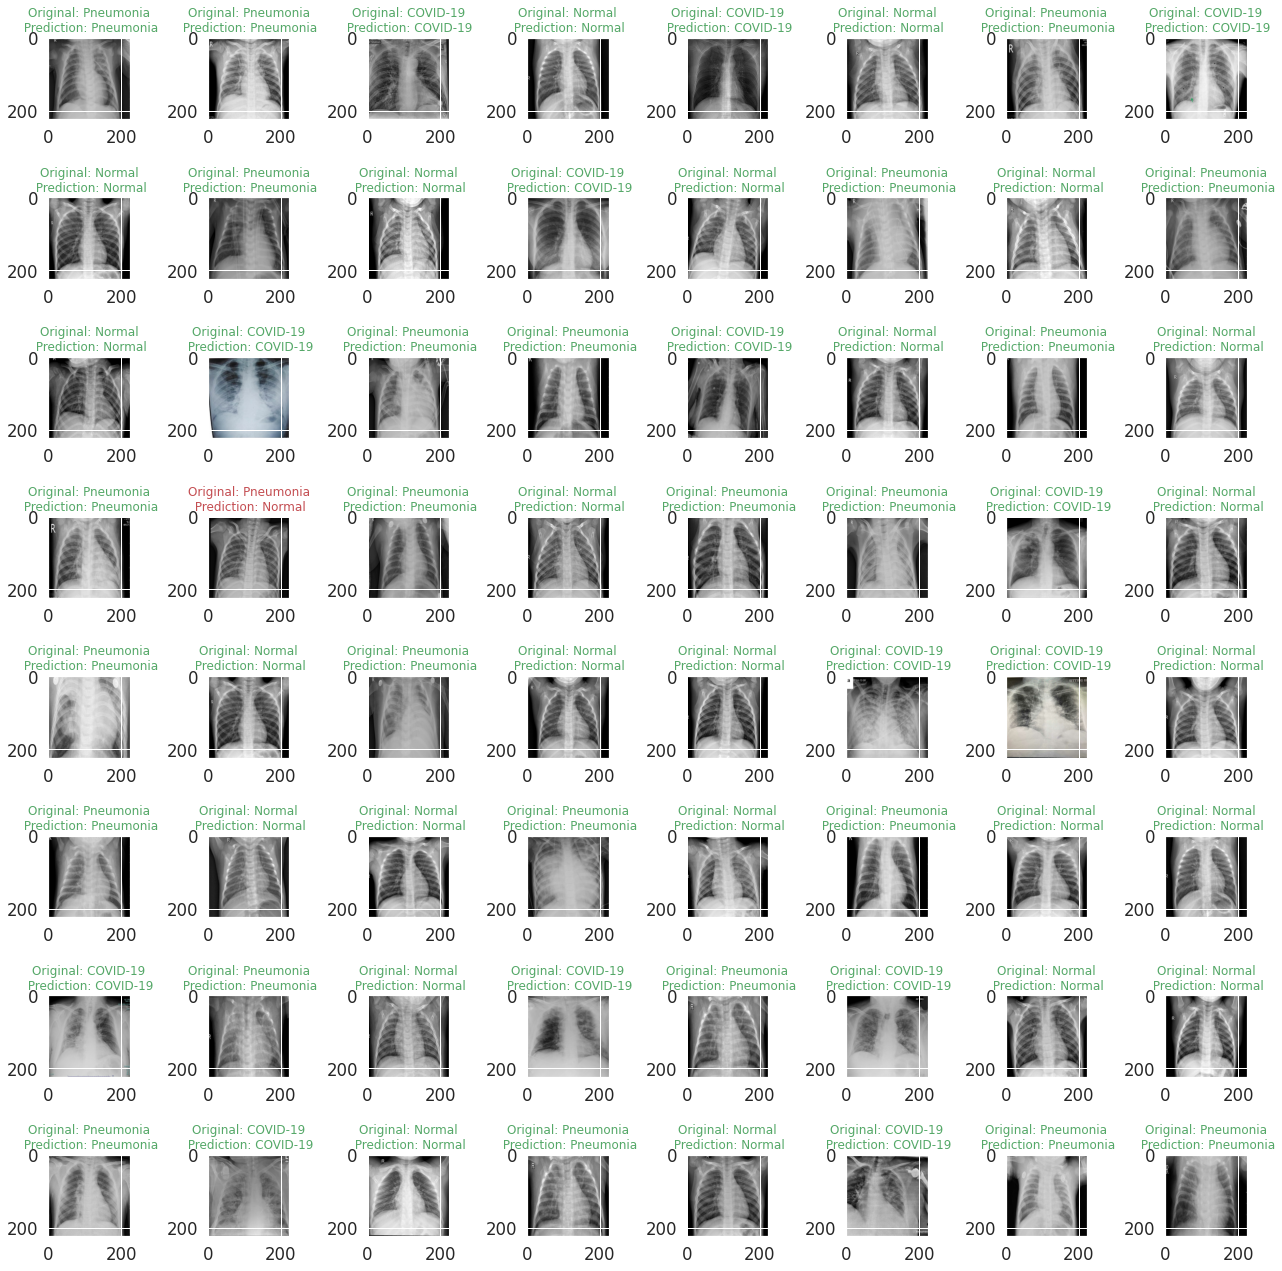

In [23]:
#visualize the results
fig = plt.figure(figsize = (18, 18))
for i in range(64):
    j = random.randint(0, len(image))
    fig.add_subplot(8, 8, i+1)
    if original[j] == prediction[j]:
      title_color = "g"
    else:
      title_color = "r"
    plt.title("Original: " + original[j] +"\n Prediction: " + prediction[j] , fontsize=12, c=title_color)
    plt.imshow(image[j])
fig.tight_layout()


### **Predic from test folder images**

### **Grad-CAM class activation visualization**

In [ ]:
# layers are in the base model
for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

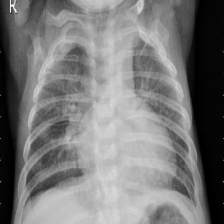

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
"""
## Configurable parameters
You can change these to another model.
To get the values for `last_conv_layer_name` use `model.summary()`
to see the names of all layers in the model.
"""
model_builder = keras.applications.efficientnet_v2.EfficientNetV2B0
img_Size = (224,224)
decode_predictions = keras.applications.efficientnet_v2.decode_predictions

last_conv_layer_name = "top_activation"

# The local path to our target image
# img_path = keras.utils.get_file(
#     "african_elephant.jpg", "https://i.imgur.com/Bvro0YD.png"
# )

# img_path = 'D:/My Research/Publish Papers/3-MultiClasses/Datasets/Curated 3Class/test/Viral-Pneumonia/Pneumonia-Viral (479).jpg'
# img_path = 'D:/My Research/Publish Papers/3-MultiClasses/Datasets/Curated 3Class/test/COVID-19/COVID-19 (26).png'
# img_path = 'D:/My Research/Publish Papers/3-MultiClasses/Datasets/Curated 3Class/test/Normal/h1322.png'

img_path = '/content/drive/MyDrive/Datasets/Curated 3Class/test/Pneumonia/Pneumonia-Bacterial (10).png'
# img_path = '/content/drive/MyDrive/Datasets/Curated 3Class/test/COVID-19/COVID-19 (1020).png'
# img_path = '/content/drive/MyDrive/Datasets/Curated 3Class/test/Normal/Normal (828).png'

display(Image(img_path, width=300))

In [ ]:
"""
## The Grad-CAM algorithm
"""
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch" of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    #array /= 255
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

Predicted: [('n01990800', 'isopod', 7.9800043)]


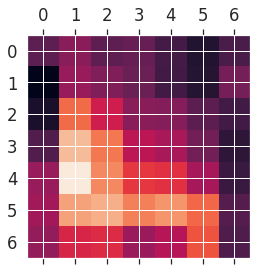

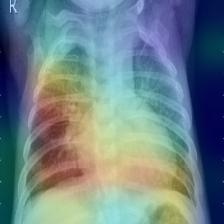

In [ ]:
"""
## Let's test-drive it
"""
# Prepare image
img_array = get_img_array(img_path, size=img_Size)

# Make model
model_weight = model_builder(weights="imagenet")

# Remove last layer's softmax
model_weight.layers[-1].activation = None

# Print what the top predicted class is
preds = model_weight.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model_weight, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

"""
## Create a superimposed visualization إنشاء تصور متراكب
"""
def save_and_display_gradcam(img_path, heatmap, cam_path="COVID-19.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path, width=300))

save_and_display_gradcam(img_path, heatmap)